<b><p style="text-align:center;font-size: 40px;"> Projet n°10</p><b>
<b><p style="text-align:center;font-size: 40px;"> Réalisez une application de recommandation de contenu</p><b>
<b><p style="text-align:center;font-size: 36px;"> Analyse Exploratoire du Dataset "News Portal User Interactions by Globo.com" </p><b>

---

# Introduction 

Ce notebook présente une analyse exploratoire (EDA) du dataset "News Portal User Interactions by Globo.com", qui regroupe les interactions de centaines de milliers d’utilisateurs avec des dizaines de milliers d’articles sur une période de plusieurs semaines. L’objectif est de comprendre les comportements des utilisateurs, la popularité des contenus, la diversité des catégories et la structure des articles à travers leurs embeddings. Cette étude servira de base à la conception d’une application de recommandation de contenu, en mettant en lumière les tendances d’usage, la similarité des articles consultés et les spécificités du portail Globo.com.

# Imports des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, pickle
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

# Structure des données
Le jeu de données "News Portal User Interactions by Globo.com" se compose de :
- 385 fichiers `clicks_hour_###.csv` représentant les clics par heure
- `articles_metadata.csv` : métadonnées de chaque article (catégorie, date de publication, nombre de mots, etc.)
- `articles_embeddings.pickle` : vecteurs d'embedding du contenu de chaque article

# Analyse des clics utilisateurs
 - On charge et concatène les clics utilisateurs sur toute la période (385 fichiers correspondant à 385 heures). Chaque ligne correspond à un clic : un utilisateur qui clique sur un article à un instant donné.

In [2]:
# Chargement de tous les clics
clicks_dir = 'news-portal-user-interactions-by-globocom/clicks'
n_hours = 385
clicks_list = []
for i in range(n_hours):
    path = os.path.join(clicks_dir, f'clicks_hour_{i:03d}.csv') 
    if os.path.exists(path):
        df = pd.read_csv(path)
        clicks_list.append(df)    
clicks = pd.concat(clicks_list, ignore_index=True)
clicks['click_timestamp'] = pd.to_datetime(clicks['click_timestamp'], unit='ms', errors='coerce')
clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,2017-10-01 03:04:07.951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,2017-10-01 03:04:50.575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,2017-10-17 03:39:17.302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,2017-10-17 03:41:12.520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,2017-10-17 03:41:42.520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,2017-10-17 03:38:33.583,4,3,2,1,25,2


In [3]:
# Statistiques de base
print(f'Nombre d"utilisateurs : {clicks["user_id"].nunique()}')
print(f'Nombre d"articles consultés : {clicks["click_article_id"].nunique()}')

Nombre d"utilisateurs : 322897
Nombre d"articles consultés : 46033


Sur la période couverte par le jeu de données, il y a donc eu 322 897 utilisateurs ayant eu des interactions avec 46 033 articles différents.

## Étude de la répartition des clics dans le temps

In [4]:
clicks["click_timestamp"].describe()

count                          2988181
mean     2017-10-08 14:51:05.606100224
min         2017-10-01 03:00:00.026000
25%      2017-10-04 14:20:52.854000128
50%      2017-10-08 20:35:30.480999936
75%      2017-10-11 19:43:24.600999936
max         2017-11-13 20:04:14.886000
Name: click_timestamp, dtype: object

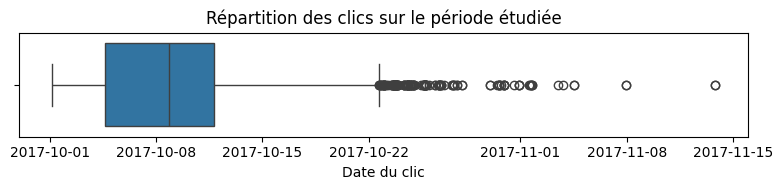

In [5]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=clicks["click_timestamp"])
plt.title("Répartition des clics sur le période étudiée")
plt.xlabel("Date du clic")
plt.tight_layout()
plt.show()

La période étudiée s'étend sur environ 6 semaines, du 1er octobre 2017 au 13 novembre 2017. Sur cette période, 75% des interactions ont été effectuées entre le 1er et le 11 octobre.

## Répartition du nombre de clics par utilisateur

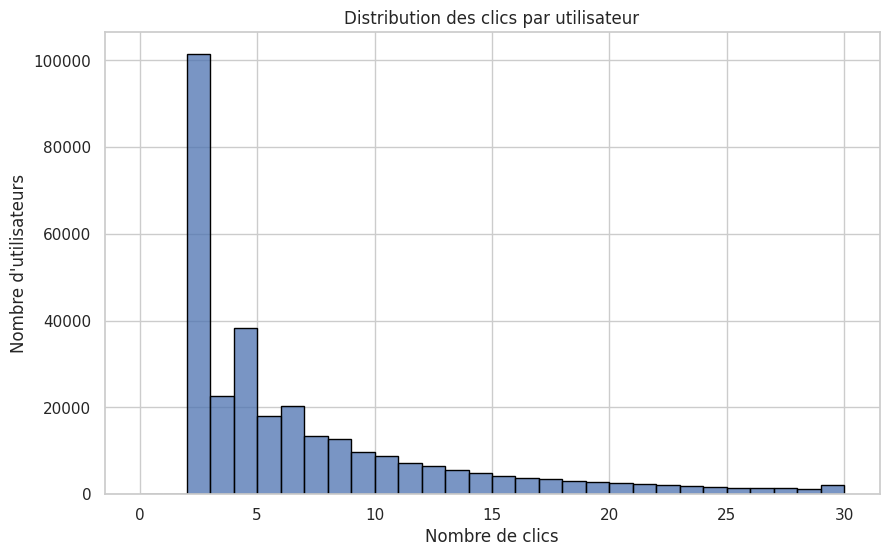

In [6]:
# Calculer le nombre de clics par utilisateur
user_click_counts = clicks['user_id'].value_counts()

# Tracer l'histogramme avec seaborn
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.histplot(user_click_counts, bins=30, binrange=(0, 30), edgecolor='black')

plt.title("Distribution des clics par utilisateur")
plt.xlabel("Nombre de clics")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

Plus de 100 000 utilisateurs (près d'un tier de l'effectif) n'ont effectué que 2 clics sur la période étudiée.

## Analyse des articles les plus consultés

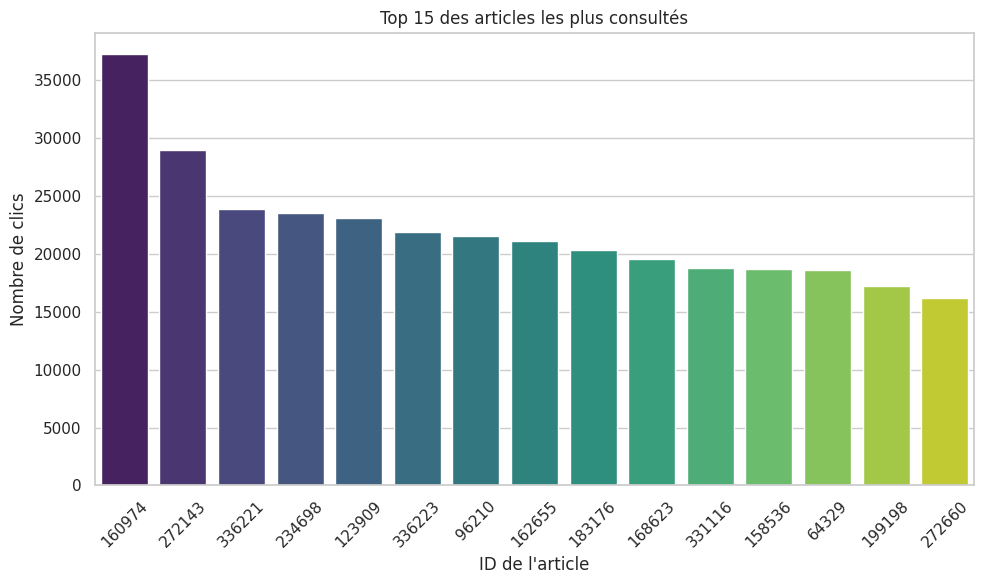

In [7]:
# Compter les clics
top_articles = (
    clicks['click_article_id']
    .value_counts()
    .head(15)
    .reset_index()
)
top_articles.columns = ['click_article_id', 'nb_clicks']

#Forcer l'ordre sur l'axe x
top_articles = top_articles.sort_values('nb_clicks', ascending=False)
top_articles['click_article_id'] = top_articles['click_article_id'].astype(str)
top_articles['click_article_id'] = pd.Categorical(
    top_articles['click_article_id'], 
    categories=top_articles['click_article_id'], 
    ordered=True
)

# Affichage
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_articles, 
    x='click_article_id', 
    y='nb_clicks', 
    hue='click_article_id',
    palette='viridis',
    legend=False
)
plt.title("Top 15 des articles les plus consultés")
plt.xlabel("ID de l'article")
plt.ylabel("Nombre de clics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
click_counts = clicks['click_article_id'].value_counts()

print(f"Nombre de clics cumulés sur les 15 articles les plus cliqués : {click_counts.head(15).sum()}")

print(f"Part des clics totaux : {(click_counts.head(15).sum()/clicks.shape[0]):.2%}")

Nombre de clics cumulés sur les 15 articles les plus cliqués : 330399
Part des clics totaux : 11.06%


Sur l'ensemble des clics effectués, plus de 10% concernait les 15 articles les plus consultés

# Analyse des articles

In [9]:
# Chargement des métadonnées articles
articles = pd.read_csv('news-portal-user-interactions-by-globocom/articles_metadata.csv')

# Afficher les premières lignes pour vérifier
display(articles)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


In [10]:
print(f'Il y a un total de {articles.shape[0]} articles différents')

Il y a un total de 364047 articles différents


Pour rappel, un peu plus de 46 000 articles ont été consultés sur la période étudiée, soit environ 12.5% des articles disponibles sur le portail Globo.com

## Étude des catégories d'articles

In [11]:
# Nombre total de catégories uniques
num_categories = articles['category_id'].nunique()
print(f'Nombre total de catégories : {num_categories}')

Nombre total de catégories : 461


- Catégories contenant le plus d'articles :

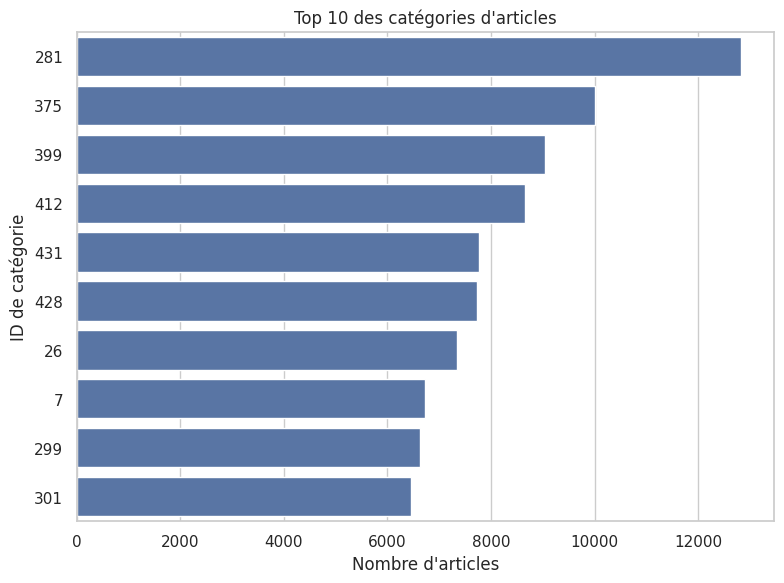

In [12]:
# Préparer les données
top_categories = articles['category_id'].value_counts().head(10)
top_categories_df = top_categories.reset_index()
top_categories_df.columns = ['category_id', 'count']

# Convertir les IDs en chaîne pour que seaborn les traite comme catégoriques
top_categories_df['category_id'] = top_categories_df['category_id'].astype(str)

# Tracer avec ordre explicite décroissant
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_categories_df,
    y='category_id',
    x='count',
    order=top_categories_df.sort_values('count', ascending=False)['category_id']
)

plt.title("Top 10 des catégories d'articles")
plt.xlabel("Nombre d'articles")
plt.ylabel("ID de catégorie")
plt.tight_layout()
plt.show()

- Répartition du nombre d'articles par catégorie

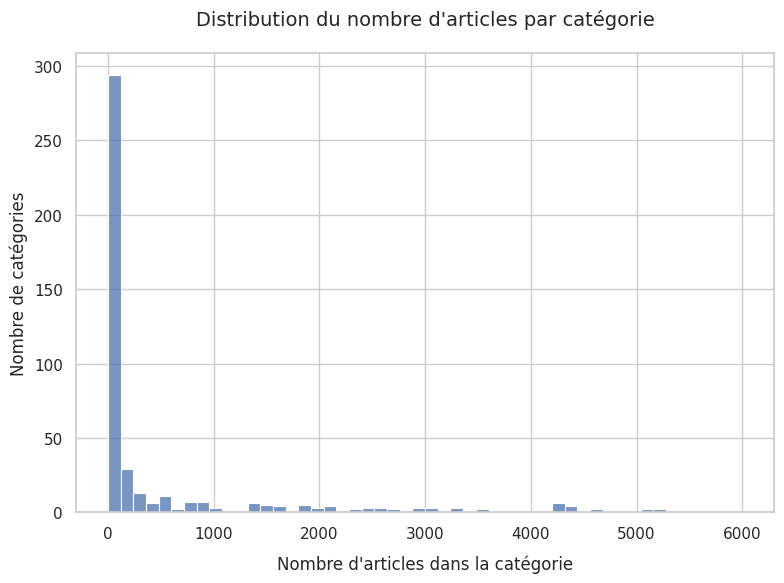

In [13]:
# Compter les articles par catégorie
category_counts = articles['category_id'].value_counts().reset_index()
category_counts.columns = ['category_id', 'count']

sns.set_theme(style="whitegrid")

# Filtrer les petites catégories
small_categories = category_counts[category_counts['count'] <= 10]

# Stats
total_categories = len(category_counts)
small_percentage = 100 * len(small_categories) / total_categories

# Création du graphique
plt.figure(figsize=(8, 6))
ax = sns.histplot(data=category_counts, x='count', bins=50, binrange=(0, 6000))

# Mise en forme
plt.title('Distribution du nombre d\'articles par catégorie', pad=20, fontsize=14)
plt.xlabel('Nombre d\'articles dans la catégorie', labelpad=10)
plt.ylabel('Nombre de catégories')

plt.tight_layout()
plt.show()

Presque 300 catégories contiennent moins de 200 articles.

## Étude des embeddings d’articles

In [14]:
# Chargement du fichier des embeddings
with open('news-portal-user-interactions-by-globocom/articles_embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)

- Dimensions des embeddings :

In [15]:
print(f'Il y a {embeddings.shape[0]} vecteurs d\'embeddings de dimension {embeddings.shape[1]}')

Il y a 364047 vecteurs d'embeddings de dimension 250


Il y a donc bien un vecteur d'embeddings par article disponible sur le portail Globo.

- Représentation des embeddings :

On sélectionnons les articles appartenant aux 5 catégories les plus représentées. On applique ensuite une réduction de dimension avec PCA (pour conserver 95% de la variance) suivie d'un t-SNE afin de projeter les vecteurs d'embeddings dans un espace 2D. Cela permet de visualiser la similarité des articles en fonction de leur catégorie.

In [16]:
# Sélection des catégories pour chaque article
sample_categories = articles['category_id']

# Récupération des vecteurs d'embedding pour tous les articles
sample_vectors = embeddings[:]

# Identification des 5 catégories les plus représentées
top5_cats = pd.Series(sample_categories).value_counts().head(5).index.tolist()

# Création d'un masque pour filtrer les articles appartenant aux 5 catégories principales
mask = np.isin(sample_categories, top5_cats)

# Filtrage des vecteurs et des catégories selon le masque
filtered_vectors = sample_vectors[mask]
filtered_categories = sample_categories[mask]

# Réduction de dimension avec PCA pour conserver 95% de la variance
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(filtered_vectors)

# Application du t-SNE pour projeter les données dans un espace 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(pca_result)

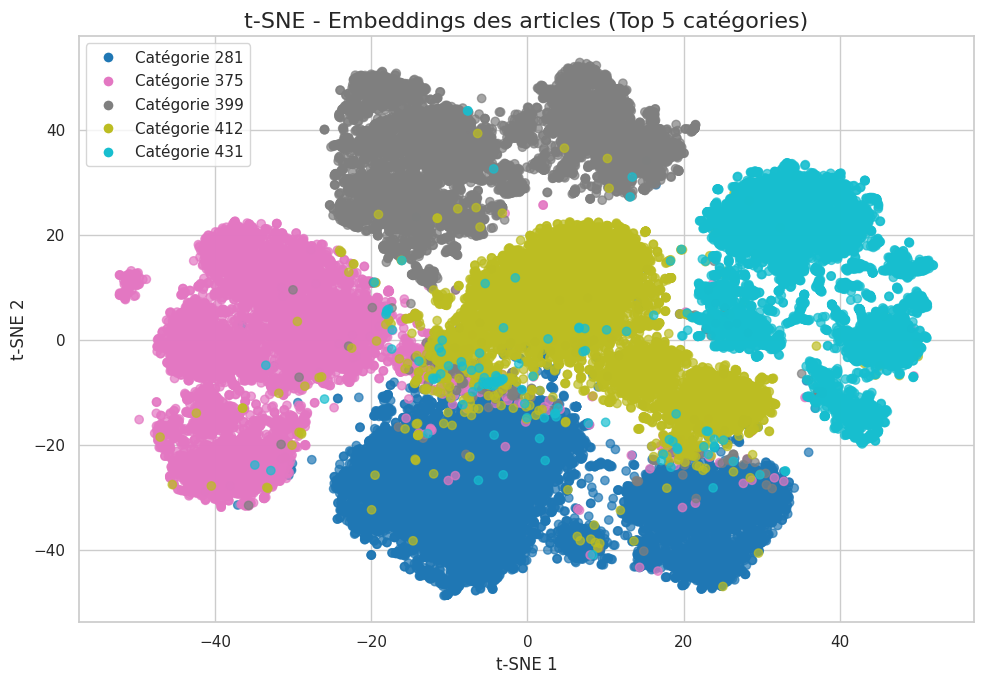

In [17]:
# Création de la figure pour la visualisation t-SNE
plt.figure(figsize=(10, 7))

# Affichage des points t-SNE, colorés selon la catégorie d'article
scatter = plt.scatter(
       tsne_result[:, 0], tsne_result[:, 1],
       c=filtered_categories, cmap='tab10', alpha=0.7
)

# Titre et axes
plt.title("t-SNE - Embeddings des articles (Top 5 catégories)", fontsize=16)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Récupération des catégories uniques pour la légende
unique_categories = np.unique(filtered_categories)

# Création des handles pour la légende, un par catégorie
handles = [
       Line2D([0], [0], marker='o', color='w',
                 label=f'Catégorie {cat}',
                 markerfacecolor=scatter.cmap(scatter.norm(cat)), markersize=8)
       for cat in unique_categories
]

# Ajout de la légende à la figure
plt.legend(handles=handles)

# Ajustement de la mise en page et affichage
plt.tight_layout()
plt.show()

Il y a une assez bonne séparation entre les catégories, les embeddings semblent donc bien refléter le rapprochement des articles au sein des catégories principales.

- Similarité entre les articles vus par chaque utilisateur

Ici, on va analyser la similiarité des articles avec lesquels chaque utilisateur a interagi.

In [18]:
def calculate_user_avg_similarity(user_id, clicks, embeddings):
    """Calcule la similarité moyenne entre les articles d'un utilisateur."""
    user_articles = clicks[clicks['user_id'] == user_id]['click_article_id'].astype(int).values
    vecs = embeddings[user_articles]

    # Normalisation des vecteurs
    norms = np.linalg.norm(vecs, axis=1, keepdims=True)
    vecs_norm = vecs / norms

    # Produit scalaire pour obtenir la matrice de similarité cosinus
    similarity_matrix = np.dot(vecs_norm, vecs_norm.T)
    np.fill_diagonal(similarity_matrix, np.nan) # Retirer la diagonale (self-similarity)
    avg_sim = np.nanmean(similarity_matrix)  # Moyenne des similarités

    return avg_sim, user_articles, similarity_matrix

Exemple pour le cas d'un utilisateur donné :

Utilisateur 123 - Similarité moyenne: 0.222


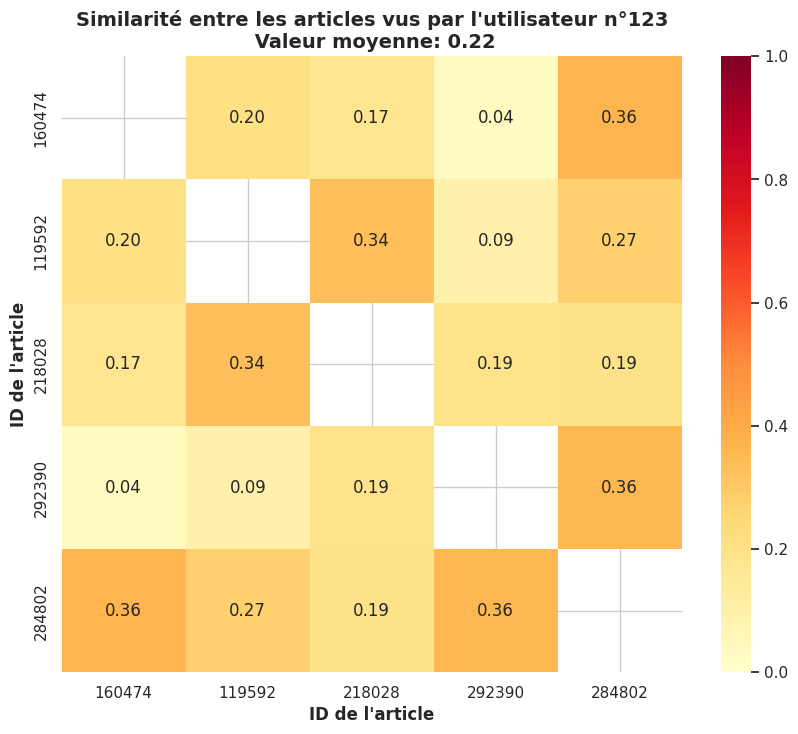

In [19]:
user_id = 123 
avg_sim, article_ids, sim_matrix = calculate_user_avg_similarity(user_id, clicks, embeddings)

print(f"Utilisateur {user_id} - Similarité moyenne: {avg_sim:.3f}")
    
# Visualisation
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.DataFrame(sim_matrix, index=article_ids, columns=article_ids),
    annot=True, 
    cmap="YlOrRd",
    vmin=0, 
    vmax=1,
    mask=np.eye(len(sim_matrix)),
    fmt=".2f"
)
plt.title(f"Similarité entre les articles vus par l'utilisateur n°{user_id}\n Valeur moyenne: {avg_sim:.2f}", fontsize=14, fontweight='bold')
plt.xlabel('ID de l\'article', fontweight='bold')
plt.ylabel('ID de l\'article', fontweight='bold')
plt.show()

Pour cet utilisateur 123, la similarité des différents articles qu'il a consulté est assez faible, avec une valeur moyenne de 0.22 et une valeur maximale de 0.36.

On va maintenant appliquer la même démarche sur plusieurs utilisateurs, en sélectionnant un échantillion aléatoirement et en calculant la similarité moyenne sur l'ensemble de l'échantillion :

In [20]:
def calculate_population_avg_similarity(clicks, embeddings, sample_size):
    # Échantillonner aléatoirement des utilisateurs
    unique_users = clicks['user_id'].unique()
    sampled_users = np.random.choice(unique_users, size=sample_size, replace=False)
    
    # Calculer les similarités moyennes
    similarities = []
    for user_id in tqdm(sampled_users, desc="Calcul des similarités moyennes par utilisateur"):
        avg_sim, _, _ = calculate_user_avg_similarity(user_id, clicks, embeddings)
        similarities.append(avg_sim)
    
    # Retourner la moyenne globale
    return np.mean(similarities) if similarities else 0.0

Calcul pour un échantillon de 20 000 utilisateurs :

In [21]:
avg_similarity = calculate_population_avg_similarity(clicks, embeddings, sample_size=20000)

Calcul des similarités moyennes par utilisateur:   0%|          | 0/20000 [00:00<?, ?it/s]

In [22]:
print(f"Moyenne des similarités pour l'échantillon: {avg_similarity:.3f}")

Moyenne des similarités pour l'échantillon: 0.332


Finalement, les utilisateurs semblent globalement consulter des articles peu similaires entre eux.

# Conclusion

Cette EDA du dataset "News Portal User Interactions by Globo.com" a mis en évidence la diversité des comportements utilisateurs et des contenus proposés. Malgré la forte concentration des clics sur quelques articles populaires, la majorité des utilisateurs consultent des articles variés et peu similaires entre eux. Les embeddings d’articles révèlent une bonne séparation entre les principales catégories. Ces observations serviront de base à la conception d’une application de recommandation adaptée aux usages et à la richesse du portail Globo.com.